### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
# Load the master dataset WITH prior grades (for initial exploration)
df = pd.read_csv('student_with_grades_encoded.csv')

#display first few rows
df.head()

,age,Medu,Fedu,traveltime_x,studytime_x,failures_x,famrel_x,freetime_x,goout_x,Dalc_x,...,guardian_y_Other,schoolsup_y_yes,famsup_y_yes,paid_y_yes,activities_y_yes,higher_y_yes,romantic_y_yes,at_risk_total_At Risk (Math Only),at_risk_total_At Risk (Port Only),at_risk_total_Not At Risk
0,18,4,4,2,2,0,4,3,4,1,...,0,1,0,0,0,1,0,1,0,0
1,17,1,1,1,2,0,5,3,3,1,...,0,0,1,0,0,1,0,1,0,0
2,15,1,1,1,2,3,4,3,2,2,...,0,1,0,0,0,1,0,0,0,1
3,15,4,2,1,3,0,3,2,2,1,...,0,0,1,0,1,1,1,0,0,1
4,16,3,3,1,2,0,4,3,2,1,...,0,0,1,0,0,1,0,0,0,1


### Prepare Features for Clustering 

In [4]:
# Separate features from target variables
# We want to exclude targets so clustering is unsupervised
target_cols = ['at_risk_math', 'at_risk_port', 'G3_x', 'G3_y', 
               'at_risk_total_At Risk (Math Only)', 
               'at_risk_total_At Risk (Port Only)',
               'at_risk_total_Not At Risk']

X = df.drop(columns=[col for col in target_cols if col in df.columns])

### Feature Scaling 

In [5]:
# K-Means uses Euclidean distance, so we MUST scale features
# StandardScaler brings all features to mean=0, std=1

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for easier interpretation
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print(f" Features scaled using StandardScaler:")
print(f"\n   Before scaling:")
print(f"   Mean: {X.mean(axis=0).mean():.2f}")
print(f"   Std: {X.std(axis=0).mean():.2f}")
print(f"\n   After scaling:")
print(f"   Mean: {X_scaled_df.mean(axis=0).mean():.4f}")
print(f"   Std: {X_scaled_df.std(axis=0).mean():.4f}")

 Features scaled using StandardScaler:

   Before scaling:
   Mean: 2.17
   Std: 0.99

   After scaling:
   Mean: -0.0000
   Std: 1.0013


In [6]:
# Store target variables for later analysis
y_risk_math = df['at_risk_math']
y_risk_port = df['at_risk_port']
y_grades_x = df['G3_x']
y_grades_y = df['G3_y']

In [7]:
#reset index in X_scaled_df to match df
X_scaled_df.reset_index(drop=True, inplace=True)

### Train/Validation Split (80/20)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(
    X_scaled_df, test_size=0.2, random_state=42, shuffle=True)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")


Train shape: (305, 69)
Validation shape: (77, 69)


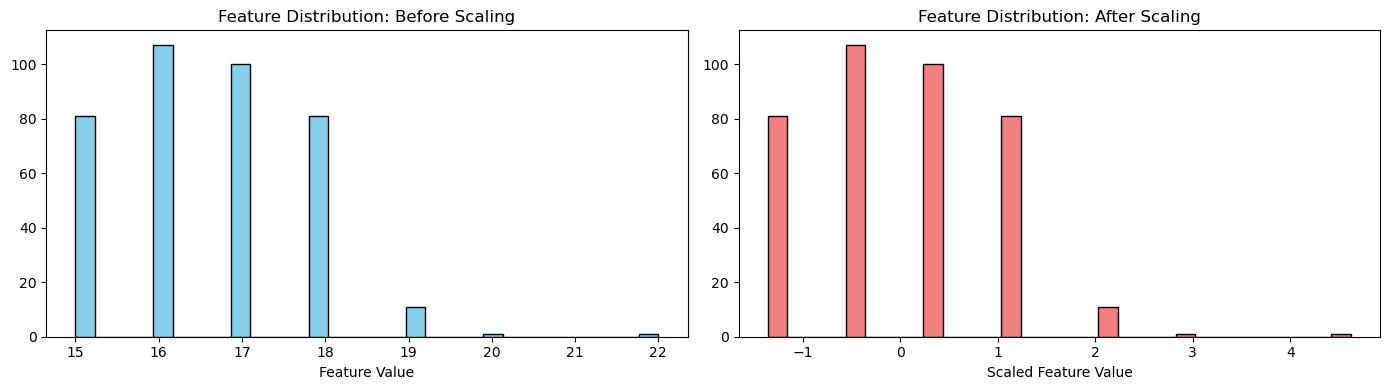

In [9]:
# Visualize scaling effect
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Before scaling
axes[0].hist(X.iloc[:, 0], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Feature Distribution: Before Scaling')
axes[0].set_xlabel('Feature Value')

# After scaling
axes[1].hist(X_scaled_df.iloc[:, 0], bins=30, color='lightcoral', edgecolor='black')
axes[1].set_title('Feature Distribution: After Scaling')
axes[1].set_xlabel('Scaled Feature Value')

plt.tight_layout()
plt.show()

### Find Optimal Number of Clusters (Elbow Method)

In [10]:
# K-Means requires us to specify number of clusters beforehand
inertias = []
silhouette_scores = []
K_range = range(2, 11)  # Test K from 2 to 10

print("🔄 Computing K-Means for K=2 to K=10...")

🔄 Computing K-Means for K=2 to K=10...


In [11]:
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    kmeans.fit(X_scaled)
    
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(sil_score)
    
    print(f"   K={k:2d}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.3f}")


c:\Users\mpari\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


   K= 2: Inertia=24470.55, Silhouette=0.129
   K= 3: Inertia=23379.78, Silhouette=0.089


c:\Users\mpari\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\mpari\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


   K= 4: Inertia=22480.69, Silhouette=0.058
   K= 5: Inertia=21637.48, Silhouette=0.054


c:\Users\mpari\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\mpari\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


   K= 6: Inertia=21125.56, Silhouette=0.052
   K= 7: Inertia=20498.83, Silhouette=0.052


c:\Users\mpari\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\mpari\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


   K= 8: Inertia=19955.71, Silhouette=0.049


c:\Users\mpari\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


   K= 9: Inertia=19618.06, Silhouette=0.046


c:\Users\mpari\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


   K=10: Inertia=19389.35, Silhouette=0.048


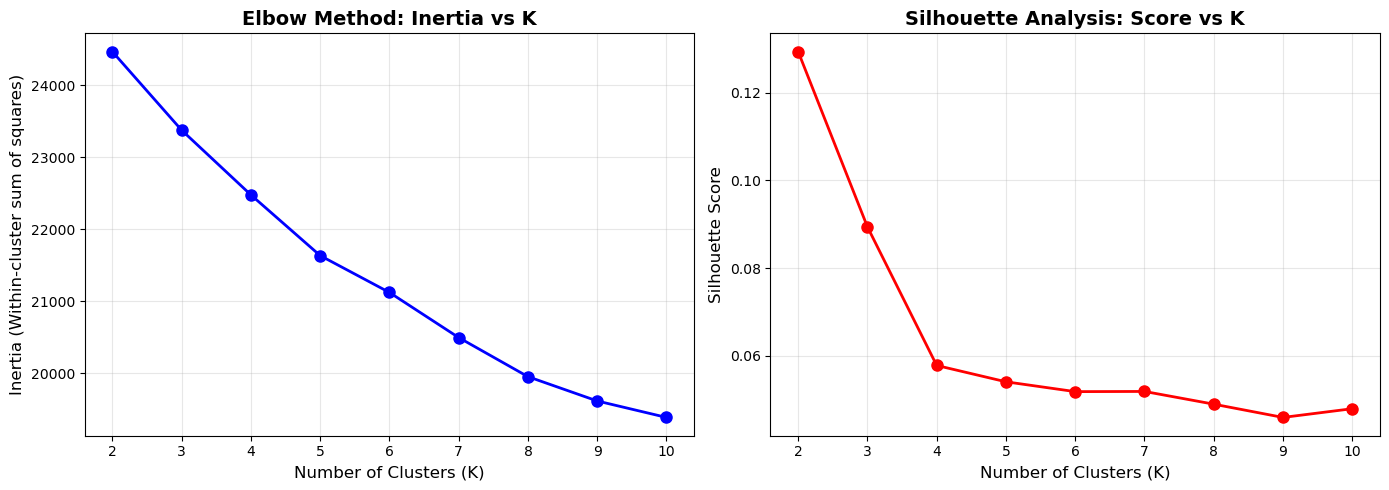

In [12]:
# Plot elbow curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Inertia plot
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
axes[0].set_title('Elbow Method: Inertia vs K', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette score plot
axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Analysis: Score vs K', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Elbow Method (Inertia vs K):
- The blue curve drops quickly from K=2 to K=5, then gradually decreases through K=6 and beyond.  The "elbow", where the rate of decrease noticeably slows is not as apparent, but we could say its around K=5. After that, further increases in K lead to only small reductions in inertia.
### Silhouette Analysis:
- The silhouette score is highest at K=2 and drops sharply until K=3, then decreases more gradually from K=4 and higher.Scores after K=3 are much lower (all below 0.06)

In [13]:
# Find optimal K based solely on silhouette score
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n Based on silhouette analysis, optimal K = {optimal_k}")
print(f"   (Highest silhouette score: {max(silhouette_scores):.3f})")


 Based on silhouette analysis, optimal K = 2
   (Highest silhouette score: 0.129)


### Train K-Means Model with K=2 first

In [14]:
# Use optimal K found above
final_k = optimal_k # or set manually based on elbow method
print(f" Training K-Means with K={final_k} clusters...")

 Training K-Means with K=2 clusters...


In [17]:
kmeans_2 = KMeans(
    n_clusters=2,
    random_state=42,
    n_init=10,           # Number of initializations (better stability)
    max_iter=300,        # Max iterations
    algorithm='lloyd'    # Standard K-Means algorithm
)

# Fit and predict
cluster_labels = kmeans_2.fit_predict(X_scaled)

print(f"\n Cluster Distribution:")
unique, counts = np.unique(cluster_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    percentage = (count / len(cluster_labels)) * 100
    print(f"   Cluster {cluster}: {count:3d} students ({percentage:5.1f}%)")

# Add cluster labels to original dataframe
df['cluster'] = cluster_labels

print(f"\n Cluster assignments added to dataframe")


 Cluster Distribution:
   Cluster 0: 288 students ( 75.4%)
   Cluster 1:  94 students ( 24.6%)

 Cluster assignments added to dataframe


c:\Users\mpari\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


### Cluster Analysis

In [24]:
# Calculate mean feature values per cluster
cluster_profiles = X_scaled_df.copy()
cluster_profiles['cluster'] = cluster_labels

# Most important engineered features to examine
key_features = ['total_absences', 'total_failures', 'mean_parent_edu', 
                'avg_study_time', 'avg_alcohol_consumption', 'family_support', 
                'school_support', 'at_risk_math', 'at_risk_port']

# Filter to available features
key_features = [f for f in key_features if f in cluster_profiles.columns]

print(f"\n📈 Mean Feature Values by Cluster:")
cluster_means = cluster_profiles.groupby('cluster')[key_features].mean()
print(cluster_means.round(3))

# Save profile for later
cluster_profiles.to_csv('cluster_profiles_analysis.csv', index=False)


📈 Mean Feature Values by Cluster:
         total_absences  total_failures  mean_parent_edu  avg_study_time  \
cluster                                                                    
0                -0.159          -0.297            0.114           0.204   
1                 0.486           0.910           -0.349          -0.626   

         avg_alcohol_consumption  family_support  school_support  
cluster                                                           
0                         -0.361           0.060           0.028  
1                          1.106          -0.183          -0.087  


#### Overall Cluster 1 has higher mean values for flagged features (cluster 1 may have more 'at risk students')

In [28]:
# Create a string code for risk combination (can use int too)
df['risk_combo'] = (
    df['at_risk_math'].astype(str) + '_' + df['at_risk_port'].astype(str)
)
print(f"\n Risk Combination Codes added to dataframe: 0_0 = Not at-risk in either subject, 1_0 = At-risk in math only, 0_1 = At-risk in Portuguese only, 1_1 = At-risk in both")

print(df['risk_combo'].value_counts())


 Risk Combination Codes added to dataframe: 0_0 = Not at-risk in either subject, 1_0 = At-risk in math only, 0_1 = At-risk in Portuguese only, 1_1 = At-risk in both
risk_combo
0_0    246
1_0    104
1_1     23
0_1      9
Name: count, dtype: int64


In [29]:
at_risk_combo_by_cluster = pd.crosstab(
    df['cluster'],
    df['risk_combo'],
    margins=True,
    normalize='index'  # Gives percentages within each cluster
)
print((at_risk_combo_by_cluster * 100).round(1))


risk_combo   0_0  0_1   1_0   1_1
cluster                          
0           72.2  0.7  25.7   1.4
1           40.4  7.4  31.9  20.2
All         64.4  2.4  27.2   6.0


* Analysis of clusters
- Cluster Differences: Cluster 0 is generally lower risk, while Cluster 1 contains predominantly at-risk students. Compared to the Portuguese risk analysis, Math has a higher overall percentage of at-risk students in both clusters, whereas Portuguese at_risk students are mostly present in Cluster 1, with cluster 0 having less than 1% of the risk students for this subject. 
- Cluster Profile Meaning: Cluster 1 likely groups students with more risk factors (more failures, less study time, lower parental education, etc.), while Cluster 0 is more moderate with fewer concentrated risk features.

#### Visualize clusters

In [21]:
# K-Means creates clusters in high dimensions
# Use PCA to reduce to 2D for visualization

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

print(f" PCA Variance Explained:")
print(f"   PC1: {pca.explained_variance_ratio_[0]*100:.1f}%")
print(f"   PC2: {pca.explained_variance_ratio_[1]*100:.1f}%")
print(f"   Total: {pca.explained_variance_ratio_.sum()*100:.1f}%")

 PCA Variance Explained:
   PC1: 10.7%
   PC2: 7.2%
   Total: 17.9%


NameError: name 'kmeans_final' is not defined

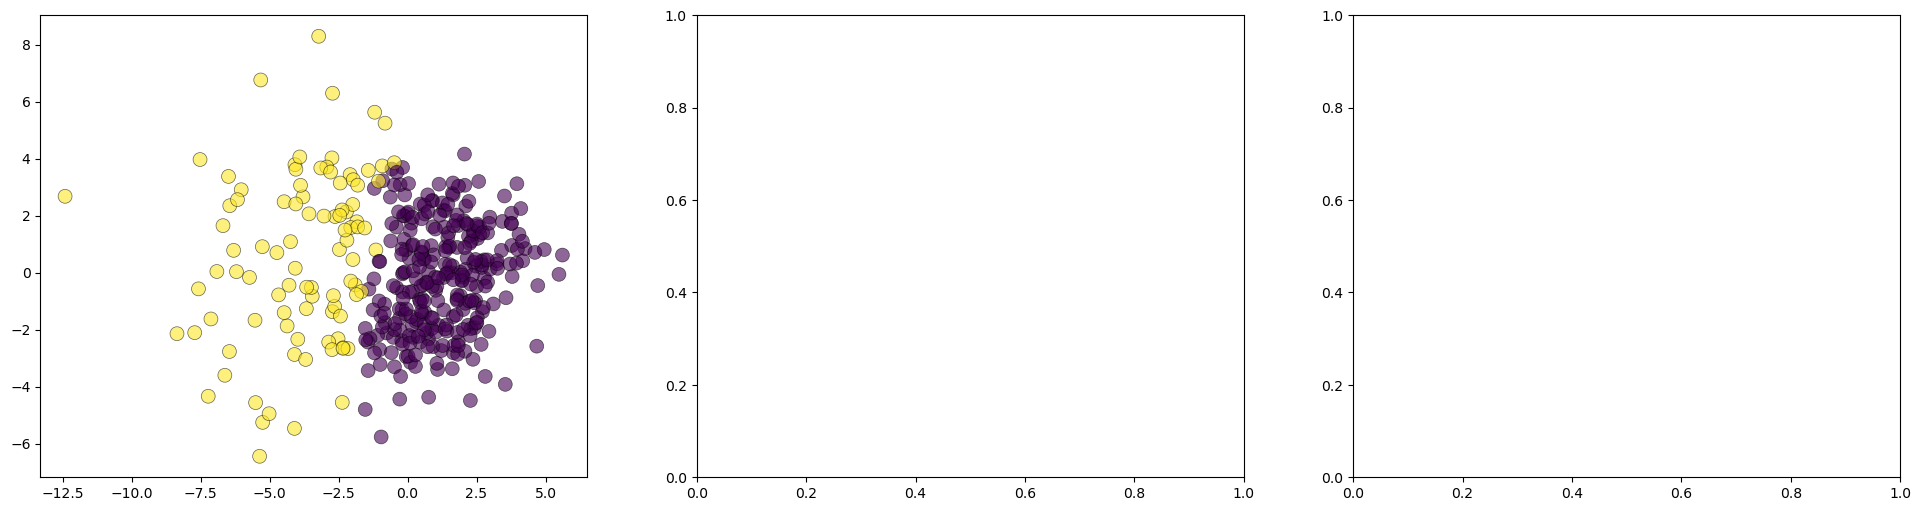

In [22]:
# Plot clusters in PCA space
fig, axes = plt.subplots(1, 3, figsize=(24, 6))  # 3 plots side by side

# --- Plot 1: Clusters ---
scatter = axes[0].scatter(
    X_pca[:, 0], X_pca[:, 1], c=cluster_labels,
    cmap='viridis', s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].scatter(
    pca.transform(kmeans_final.cluster_centers_)[:, 0],
    pca.transform(kmeans_final.cluster_centers_)[:, 1],
    c='red', marker='X', s=300, edgecolors='black', linewidth=2,
    label='Cluster Centers')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
axes[0].set_title('K-Means Clusters (PCA Visualization)', fontsize=14, fontweight='bold')
axes[0].legend()
plt.colorbar(scatter, ax=axes[0], label='Cluster')

# --- Plot 2: At-Risk Status Overlaid (Math) ---
at_risk_status_math = df['at_risk_math']
scatter_math = axes[1].scatter(
    X_pca[:, 0], X_pca[:, 1], c=at_risk_status_math,
    cmap='RdYlGn_r', s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
axes[1].set_title('At-Risk Math Status Overlaid', fontsize=14, fontweight='bold')
plt.colorbar(scatter_math, ax=axes[1], label='At-Risk (Math)')

# --- Plot 3: At-Risk Status Overlaid (Portuguese) ---
at_risk_status_port = df['at_risk_port']
scatter_port = axes[2].scatter(
    X_pca[:, 0], X_pca[:, 1], c=at_risk_status_port,
    cmap='RdYlGn_r', s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
axes[2].set_title('At-Risk Portuguese Status Overlaid', fontsize=14, fontweight='bold')
plt.colorbar(scatter_port, ax=axes[2], label='At-Risk (Portuguese)')

plt.tight_layout()
plt.show()


- Clusters reflect real risk patterns: If clusters in the left plot correspond with regions dominated by at-risk students in the middle and right plots, K-Means is capturing meaningful differences that relate to academic risk.

- Math risk is more concentrated: At-risk Math students tend to cluster more, while Portuguese risk is more sporadic, meaning risk factors for Math may be easier to group or identify with this data.

#### Silhouette analysis

 Silhouette Analysis:
   Average Silhouette Score: 0.143
   (Range: -1 to 1; Higher is better)


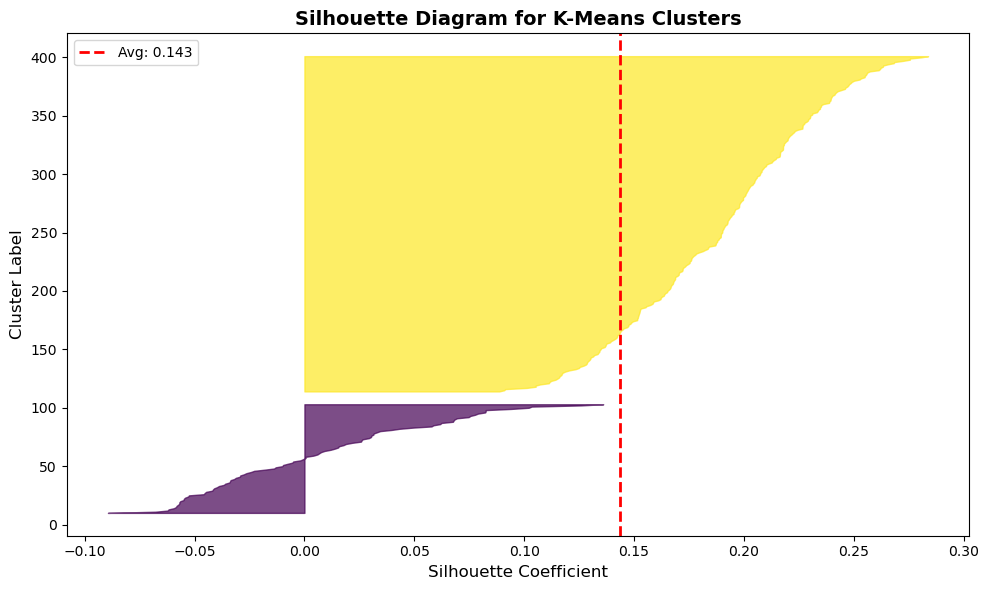

In [ ]:
# Shows how well each point fits in its cluster
# Score ranges from -1 (wrong cluster) to 1 (perfect fit)

silhouette_vals = silhouette_samples(X_scaled, cluster_labels)
silhouette_avg = silhouette_score(X_scaled, cluster_labels)

print(f" Silhouette Analysis:")
print(f"   Average Silhouette Score: {silhouette_avg:.3f}")
print(f"   (Range: -1 to 1; Higher is better)")

# Plot silhouette diagram
fig, ax = plt.subplots(figsize=(10, 6))

y_lower = 10
colors = plt.cm.viridis(np.linspace(0, 1, final_k))

for i in range(final_k):
    cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_vals,
                      facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    
    y_lower = y_upper + 10

ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=2, label=f'Avg: {silhouette_avg:.3f}')
ax.set_xlabel("Silhouette Coefficient", fontsize=12)
ax.set_ylabel("Cluster Label", fontsize=12)
ax.set_title("Silhouette Diagram for K-Means Clusters", fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()



- The average silhouette score (0.143) is positive and moderately above zero—clusters are somewhat but not extremely distinct.

- Yellow cluster: Most points have a silhouette score >0 (good cluster cohesion), but several points are close to zero.

- Purple cluster: Contains some points with negative silhouette scores—these may be 'between' clusters or not well grouped.

- Cluster size imbalance: One cluster dominates, meaning K-Means separated most students into one group, with the other much smaller. (there are more not at risk students)

#### Cluster interpretation and insights

In [ ]:
for cluster_id in range(final_k):
    cluster_mask = df['cluster'] == cluster_id
    cluster_data = df[cluster_mask]
    
    print(f"\n{'='*70}")
    print(f"🔍 CLUSTER {cluster_id}")
    print(f"{'='*70}")
    print(f"Size: {cluster_mask.sum()} students ({cluster_mask.sum()/len(df)*100:.1f}%)")
    
    # At-risk percentage
    at_risk_pct = cluster_data['at_risk_math'].mean() * 100
    print(f"At-Risk (Math): {at_risk_pct:.1f}%")
    
    # Key characteristics
    print(f"\n📊 Key Characteristics:")
    print(f"   Avg Age: {cluster_data['age'].mean():.1f} years")
    print(f"   Avg Study Time: {cluster_data['avg_study_time'].mean():.2f} hours/week")
    print(f"   Avg Failures: {cluster_data['total_failures'].mean():.2f}")
    print(f"   Avg Absences: {cluster_data['total_absences'].mean():.1f}")
    print(f"   Avg Parent Education: {cluster_data['mean_parent_edu'].mean():.2f}")
    print(f"   Family Support: {cluster_data['family_support'].mean()*100:.1f}%")
    
    # Assign descriptive name
    if at_risk_pct > 50:
        profile = "🔴 HIGH-RISK CLUSTER"
    elif at_risk_pct > 30:
        profile = "🟠 MODERATE-RISK CLUSTER"
    else:
        profile = "🟢 LOW-RISK CLUSTER"
    
    print(f"\n   Profile: {profile}")


🔍 CLUSTER 0
Size: 94 students (24.6%)
At-Risk (Math): 52.1%

📊 Key Characteristics:
   Avg Age: 17.0 years
   Avg Study Time: 1.51 hours/week
   Avg Failures: 1.41
   Avg Absences: 12.1
   Avg Parent Education: 2.34
   Family Support: 54.3%

   Profile: 🔴 HIGH-RISK CLUSTER

🔍 CLUSTER 1
Size: 288 students (75.4%)
At-Risk (Math): 27.1%

📊 Key Characteristics:
   Avg Age: 16.5 years
   Avg Study Time: 2.21 hours/week
   Avg Failures: 0.11
   Avg Absences: 7.0
   Avg Parent Education: 2.80
   Family Support: 66.0%

   Profile: 🟢 LOW-RISK CLUSTER


In [ ]:
for cluster_id in range(final_k):
    cluster_mask = df['cluster'] == cluster_id
    cluster_data = df[cluster_mask]
    
    print(f"\n{'='*70}")
    print(f"🔍 CLUSTER {cluster_id}")
    print(f"{'='*70}")
    print(f"Size: {cluster_mask.sum()} students ({cluster_mask.sum()/len(df)*100:.1f}%)")
    
    # At-risk percentage portuguese
    at_risk_pct = cluster_data['at_risk_port'].mean() * 100
    print(f"At-Risk (Portuguese): {at_risk_pct:.1f}%")
    
    # Key characteristics
    print(f"\n📊 Key Characteristics:")
    print(f"   Avg Age: {cluster_data['age'].mean():.1f} years")
    print(f"   Avg Study Time: {cluster_data['avg_study_time'].mean():.2f} hours/week")
    print(f"   Avg Failures: {cluster_data['total_failures'].mean():.2f}")
    print(f"   Avg Absences: {cluster_data['total_absences'].mean():.1f}")
    print(f"   Avg Parent Education: {cluster_data['mean_parent_edu'].mean():.2f}")
    print(f"   Family Support: {cluster_data['family_support'].mean()*100:.1f}%")
    
    # Assign descriptive name
    if at_risk_pct > 50:
        profile = "🔴 HIGH-RISK CLUSTER"
    elif at_risk_pct > 30:
        profile = "🟠 MODERATE-RISK CLUSTER"
    else:
        profile = "🟢 LOW-RISK CLUSTER"
    
    print(f"\n   Profile: {profile}")


🔍 CLUSTER 0
Size: 94 students (24.6%)
At-Risk (Portuguese): 27.7%

📊 Key Characteristics:
   Avg Age: 17.0 years
   Avg Study Time: 1.51 hours/week
   Avg Failures: 1.41
   Avg Absences: 12.1
   Avg Parent Education: 2.34
   Family Support: 54.3%

   Profile: 🟢 LOW-RISK CLUSTER

🔍 CLUSTER 1
Size: 288 students (75.4%)
At-Risk (Portuguese): 2.1%

📊 Key Characteristics:
   Avg Age: 16.5 years
   Avg Study Time: 2.21 hours/week
   Avg Failures: 0.11
   Avg Absences: 7.0
   Avg Parent Education: 2.80
   Family Support: 66.0%

   Profile: 🟢 LOW-RISK CLUSTER


### COMPARE: WITH vs WITHOUT PRIOR GRADES

In [ ]:
# Load the second dataset (without prior grades)
df_no_grades = pd.read_csv('student_without_grades_encoded.csv')

# Prepare and scale
target_cols_no_grades = ['at_risk_math', 'at_risk_port',
                         'at_risk_total_At Risk (Math Only)', 
                         'at_risk_total_At Risk (Port Only)',
                         'at_risk_total_Not At Risk']

X_no_grades = df_no_grades.drop(columns=[col for col in target_cols_no_grades if col in df_no_grades.columns])
X_no_grades_scaled = scaler.fit_transform(X_no_grades)

# Train K-Means on no-grades data
kmeans_no_grades = KMeans(n_clusters=final_k, random_state=RANDOM_STATE, n_init=10)
labels_no_grades = kmeans_no_grades.fit_predict(X_no_grades_scaled)

# Compare metrics
sil_with = silhouette_score(X_scaled, cluster_labels)
sil_without = silhouette_score(X_no_grades_scaled, labels_no_grades)

print("\n" + "="*70)
print("COMPARISON: WITH vs WITHOUT PRIOR GRADES")
print("="*70)
print(f"Silhouette Score (WITH grades):    {sil_with:.3f}")
print(f"Silhouette Score (WITHOUT grades): {sil_without:.3f}")
print(f"\nDifference: {(sil_with - sil_without):.3f}")
print(f"\nInterpretation:")
if sil_with > sil_without:
    print(f" Prior grades improve cluster quality by {abs(sil_with - sil_without):.1%}")
else:
    print(f" Clustering works well even WITHOUT prior grades!")



COMPARISON: WITH vs WITHOUT PRIOR GRADES
Silhouette Score (WITH grades):    0.143
Silhouette Score (WITHOUT grades): 0.133

Difference: 0.010

Interpretation:
 Prior grades improve cluster quality by 1.0%


c:\Users\mpari\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


### Evaluating K-Means (K=2) on Validation Data

In [ ]:
# Predict cluster labels for validation set
val_labels = kmeans_final.predict(X_val)

c:\Users\mpari\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [ ]:
val_df = pd.DataFrame(X_val, columns=X_val.columns)
val_df['cluster'] = val_labels
val_df['at_risk_math'] = df.iloc[X_val.index]['at_risk_math'].values


In [ ]:
# Compare at-risk proportions in each validation cluster
crosstab_val = pd.crosstab(
    val_df['cluster'], val_df['at_risk_math'], normalize='index'
)
print((crosstab_val * 100).round(1))


at_risk_math     0     1
cluster                 
0             36.8  63.2
1             79.3  20.7


In [ ]:
# Pick the cluster with higher proportion of at-risk students as 'predicted at-risk'
at_risk_cluster = crosstab_val[1].idxmax()  # Cluster with most at-risk

# Create predicted labels: 1 if in at-risk cluster, else 0
val_df['predicted_at_risk'] = (val_df['cluster'] == at_risk_cluster).astype(int)

# Confusion matrix and metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

cm = confusion_matrix(val_df['at_risk_math'], val_df['predicted_at_risk'])
print('Confusion Matrix (Validation Set):')
print(cm)
print(f'Accuracy:  {accuracy_score(val_df["at_risk_math"], val_df["predicted_at_risk"]):.2f}')
print(f'Precision: {precision_score(val_df["at_risk_math"], val_df["predicted_at_risk"]):.2f}')
print(f'Recall:    {recall_score(val_df["at_risk_math"], val_df["predicted_at_risk"]):.2f}')
print(f'F1 Score:  {f1_score(val_df["at_risk_math"], val_df["predicted_at_risk"]):.2f}')


Confusion Matrix (Validation Set):
[[46  7]
 [12 12]]
Accuracy:  0.75
Precision: 0.63
Recall:    0.50
F1 Score:  0.56


_What each value means_:
- 46: True Negatives: not at risk, clustered as not at risk
- 7: False Positives: not at risk, but clustered as at risk
- 12: False Negatives: at risk, but clustered as not at risk
- 12: True Positives: at risk, clustered as at risk <br>

_Metrics_
- Accuracy (0.75): 75% of students were put in the correct at-risk/not-at-risk group by the clusters.
- Precision (0.63): Of all students the model predicted as at-risk (clustered with the higher at-risk group), 63% were truly at risk. (How trustworthy is a cluster's 'at-risk' label?)
- Recall (0.50): Of all students actually at risk, 50% were grouped into the at-risk cluster. (How many at-risk kids did we catch?)
- F1 Score (0.56): The balance between precision & recall (a measure of overall classification performance).
